In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import mygene

# Analysis of TCGA Tumor vs Normal Differential Expression

Using data produced from this experiment: <br>
https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/tcga_tumor_vs_normal.py 

### Number of samples



In [5]:
def zip_sort(x, y):
    vals = sorted(zip(x, y), key=lambda x: x[1])
    return zip(*vals)

def label_fix(l):
    return [x.replace('_', '\n').capitalize() for x in l]

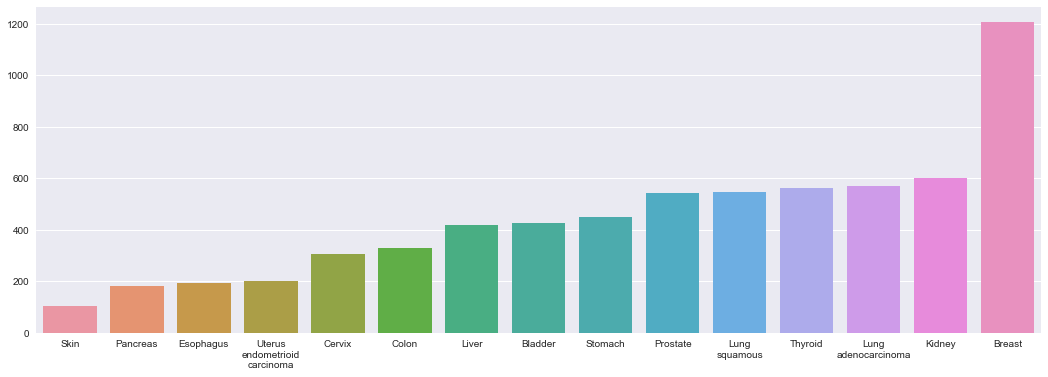

In [65]:
vector_names = [x.split('-vector')[0].replace('_', '\n').capitalize() for x in os.listdir('vectors/') if '-vector' in x]
num_samples = [len(open(os.path.join('vectors', x)).readlines()) for x in os.listdir('vectors/') if '-vector' in x]

vector_names, num_samples = zip_sort(vector_names, num_samples)

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(vector_names, num_samples, ax=ax);

### Significant Genes

Read in results from DESeq2

In [2]:
result_paths = [x for x in os.listdir('results') if '.tsv' in x]
results = {}
for result in result_paths:
    results[result.split('-')[0]] = pd.read_csv(os.path.join('results', result), index_col=0, sep='\t')

In [73]:
results['bladder'].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geneId
EPM2A,241.821129,-2.688553,0.184879,-14.542257,6.540009e-48,1.235669e-43,ENSG00000112425.13
SLMAP,3284.985396,-2.683411,0.185645,-14.454511,2.347926e-47,2.218086e-43,ENSG00000163681.14
PLCD4,145.740916,-3.309799,0.243494,-13.592928,4.410739e-42,2.777883e-38,ENSG00000115556.13
LMOD3,17.728017,-3.932175,0.289943,-13.561896,6.737188e-42,3.182311e-38,ENSG00000163380.15
SRF,3363.439365,-1.716478,0.129178,-13.287715,2.727835e-40,1.030794e-36,ENSG00000112658.7


Positive log2FoldChange are gain of function for TUMOR <br>
Negative log2FoldChnage are loss of function for TUMOR

In [3]:
sig_genes = {x: results[x][results[x].padj < 0.001].index for x in [y.split('-')[0] for y in result_paths]}

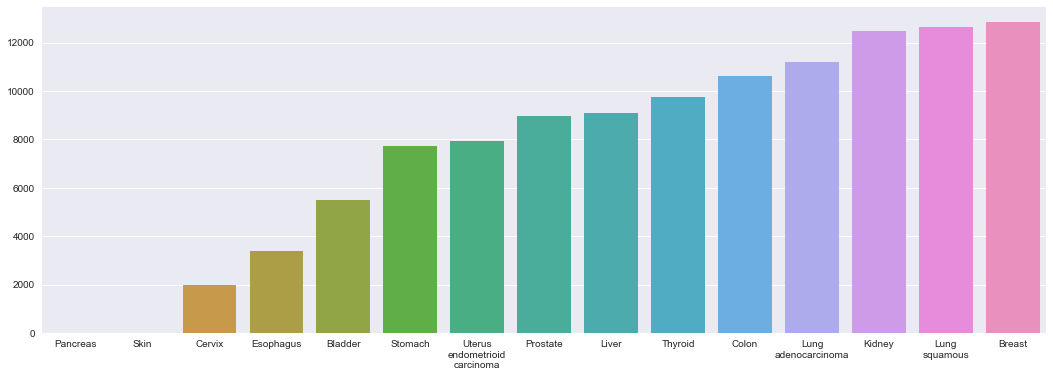

In [6]:
genes = [x.replace('_', '\n').capitalize() for x in sorted(sig_genes.keys())]
x, y = zip_sort(genes, [len(sig_genes[x]) for x in sorted(sig_genes.keys())])

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(x, y, ax=ax);

Pancreas, Skin, Cervix and possibly Esophagus are likely not worth examining as their normal tissue sample size was 4, 1, 3, and 13 respectively. 

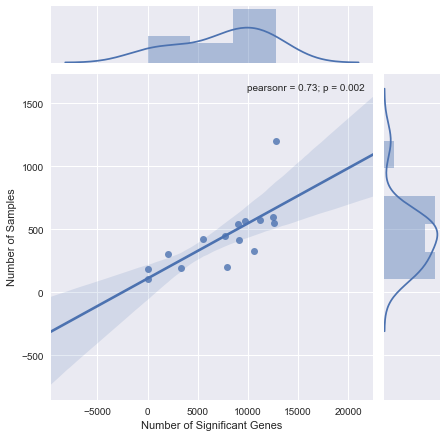

In [26]:
num_samples = np.array([len(open(os.path.join('vectors', x)).readlines()) for x in sorted(os.listdir('vectors/')) if '-vector' in x])
num_sig = np.array([len(sig_genes[x]) for x in sorted(sig_genes.keys())])
sns.jointplot(num_sig, num_samples, kind='reg')
plt.xlabel('Number of Significant Genes')
plt.ylabel('Number of Samples');

## Overlap Heatmap

In [27]:
n = 100
top_hits = {x: results[x].head(n).index for x in [y.split('-')[0] for y in result_paths]}

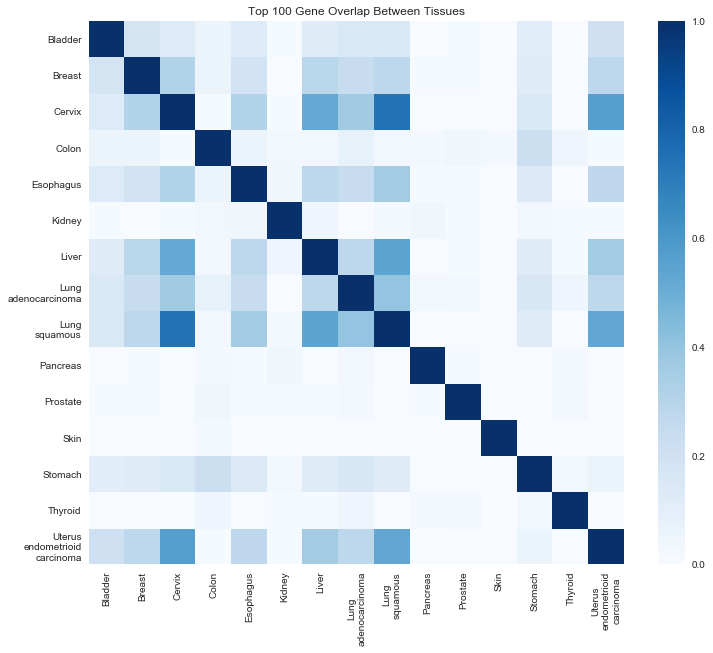

In [28]:
overlap = []
tissues = sorted(top_hits.keys())
for tissue in tissues:
    overlap.append([float(len(set(top_hits[tissue]).intersection(set(top_hits[x]))))/n for x in tissues])
overlap = pd.DataFrame(overlap)
overlap.index = label_fix(tissues)
overlap.columns = label_fix(tissues)

fig, ax = plt.subplots(figsize=[12,10])
sns.heatmap(overlap, ax=ax, cmap='Blues')
plt.title('Top {} Gene Overlap Between Tissues'.format(n));

## Gene Annotation

In [29]:
def get_basic_gene_info(gene_list):
    mg = mygene.MyGeneInfo()
    return mg.querymany(gene_list, 
                        scopes='symbol', 
                        fields='symbol,name,entrezgene,summary', 
                        species='human', 
                        returnall=True, 
                        as_dataframe=True, 
                        size=1)

## Write Out Values

In [30]:
try:
    os.mkdir('analysis')
    os.mkdir('analysis/sig-genes')
    os.mkdir('analysis/top-100-genes')
    os.mkdir('analysis/annotations')
except OSError:
    pass

#### Significantly Expressed Genes

In [31]:
sig_path = 'analysis/sig-genes'
for result in results:
    df = results[result]
    sig_genes = df[df.padj < 0.001]
    upreg = sig_genes[sig_genes.log2FoldChange > 0]
    downreg = sig_genes[sig_genes.log2FoldChange < 0]
    with open(os.path.join(sig_path, result + '-upreg.txt'), 'w') as f:
        f.write('\n'.join(upreg.index))
    with open(os.path.join(sig_path, result + '-downreg.txt'), 'w') as f:
        f.write('\n'.join(downreg.index))

#### Top Genes

In [6]:
top_path = 'analysis/top-500-genes'
for result in results:
    df = results[result]
    df = df.head(500)
    with open(os.path.join(top_path, result + '.txt'), 'w') as f:
        f.write('\n'.join(df.index))

#### Annotations

In [33]:
annotations_path = 'analysis/annotations'
for result in results:
    df = results[result]
    sig_genes = df[df.padj < 0.001]
    upreg = sig_genes[sig_genes.log2FoldChange > 0].index
    downreg = sig_genes[sig_genes.log2FoldChange < 0].index
    # Query gene server
    up_info = get_basic_gene_info(upreg)
    up_info['out'].to_csv(os.path.join(annotations_path, result + '-up-annotations.tsv'), sep='\t')
    down_info = get_basic_gene_info(downreg)
    down_info['out'].to_csv(os.path.join(annotations_path, result + '-down-annotations.tsv'), sep='\t')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5169...done.
Finished.
4 input query terms found dup hits:
	[(u'RNASE11', 2), (u'FAM47E-STBD1', 2), (u'ADORA3', 2), (u'SOGA3', 2)]
83 input query terms found no hit:
	[u'PVRL4', u'SLMO1', u'C19orf26', u'LPPR3', u'CCDC64B', u'FAM132A', u'AL589743.1', u'LPPR2', u'PPAP2
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4598...done.
Finished.
3 input query terms found dup hits:
	[(u'CLN3', 2), (u'RPP14', 2), (u'SNURF', 2)]
82 input query terms found no hit:
	[u'WBP5', u'NDNL2', u'CCDC176', u'C9orf156', u'C11orf30', u'FAM63A', u'CCDC67', u'C5orf28', u'NGFRAP
querying 1-1000...done.
querying 1001-1237...done.
Finished.
1 input query terms found dup hits:
	[(u'PAK6', 2)]
22 input query terms found no hit:
	[u'SGOL1', u'CASC5', u'KIAA0101', u'CCDC64', u'SGOL2', u'PVRL4', u'PVRL1', u

KeyError: 'query'

## Concordance Between Matched and TCGA Tumor vs Normal Experiments

In [47]:
result_paths = [x for x in os.listdir('results') if '.tsv' in x]
tcga_results = {}
for result in result_paths:
    tcga_results[result.split('-')[0]] = pd.read_csv(os.path.join('results', result), index_col=0, sep='\t')

In [48]:
result_paths = [x for x in os.listdir('../tcga-matched/results') if '.tsv' in x]
matched_results = {}
for result in result_paths:
    matched_results[result.split('-')[0]] = pd.read_csv(os.path.join('../tcga-matched/results', result), index_col=0, sep='\t')

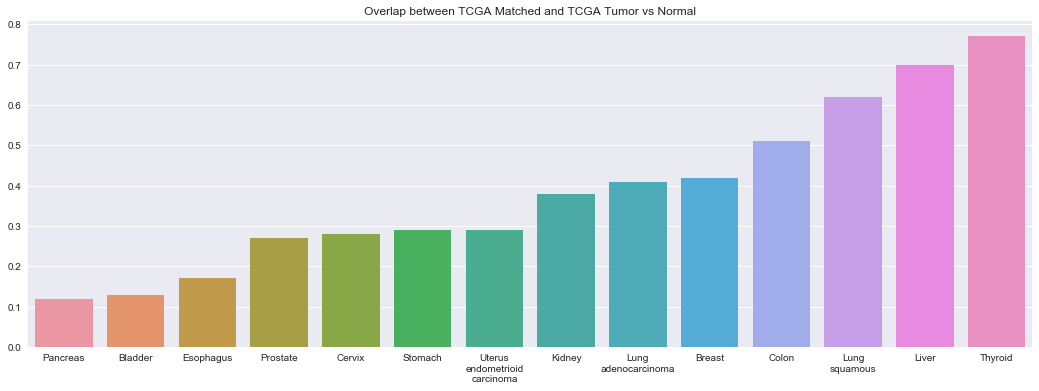

In [49]:
overlap = []
n = 100
tissues = sorted(matched_results.keys())
for tissue in tissues:
    overlap.append(float(len(set(tcga_results[tissue].head(n).index).intersection(
                        set(matched_results[tissue].head(n).index))))/n)

names = label_fix(tissues)
names, overlap = zip_sort(names, overlap)
fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(names, overlap, ax=ax)
plt.title('Overlap between TCGA Matched and TCGA Tumor vs Normal');

## Number of Samples — Tumor / Normal

In [ ]:
num_samples = []
for x in os.listdir('vectors/'):
    if '-vector' in x:
        with open('vectors/' + x, 'r') as f:
            lines = f.readlines()
            num_tumor = len([x for x in lines if x.strip().endswith('.01')])
            num_normal = len([x for x in lines if x.strip().endswith('.11')])
            num_samples.extend([num_tumor, num_normal])

In [ ]:
tissues = sorted(tcga_results.keys())

In [ ]:
df = pd.DataFrame()
df['tissue'] = [x for x in tissues for _ in (0, 1)]
df['type'] = ['Tumor', 'Normal'] * 15
df['num_samples'] = num_samples

In [ ]:
fig, ax = plt.subplots(figsize=[22,6])
sns.barplot('tissue', 'num_samples', hue='type', data=df, ax=ax);

### Cancer Predisposition Genes

In [ ]:
cpg = pd.read_csv('cancer_predisoposition_genes.tsv', sep='\t')
cp_genes = set(cpg.gene)
len(cp_genes)

In [ ]:
ax.scatter([x for x in xrange(len(tissues))], [7 for _ in xrange(len(tissues))])
cp_intersect = [len(cp_genes.intersection(set(tcga_results[x].head(n).index))) for x in tissues]

x, y = zip_sort(label_fix(tissues), cp_intersect)
f, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x, y, ax=ax)
ax.plot([x for x in xrange(len(tissues))], [7 for _ in xrange(len(tissues))], 'k--')
plt.title('Number of Intersected Genes in Cancer Predisposition List (PCAWG)')
plt.ylabel('Number of Intersected Genes');

At our sample subset of k=500, pval < 0.05 for x >= 7 given the hypergeometric distribution:

$$P( X >= x | N, m, k) = 1 - \sum_{i=0}^{x-1} P(i | N, m, k)  $$

<center> where <br>

$$P(i | N, m, k) = \frac{{m \choose x}{N-m \choose k-x}}{N \choose k} $$

It should be noted that the _Cancer Predisposition List_ contains genes associated with pancancers as well as specific types of cancer / tissues, so our value for `m`, which corresponds to the number of genes in that list, is artificially high for most of the comparisons.

I used [this calculator](https://www.geneprof.org/GeneProf/tools/hypergeometric.jsp) for convenience.

### Isolate Up / Down Regulated

We only looked at top genes, but we can be more precise by only looking at up / down regulated

In [45]:
cpg_up = cpg[cpg.mechanism == 'gain-of-function']
cpg_down = cpg[cpg.mechanism == 'loss-of-function']
print len(cpg_up), len(cpg_down)

15 114


In [78]:
n = 500
up_intersect = []
down_intersect = []
for t in tissues:
    df = tcga_results[t]
    up_genes = df[df.log2FoldChange > 0].head(n).index
    down_genes = df[df.log2FoldChange < 0].head(n).index
    
    up_intersect.append(len(set(cpg_up.gene).intersection(set(up_genes))))
    down_intersect.append(len(set(cpg_down.gene).intersection(set(down_genes))))

In [76]:
len(up_intersect)

14

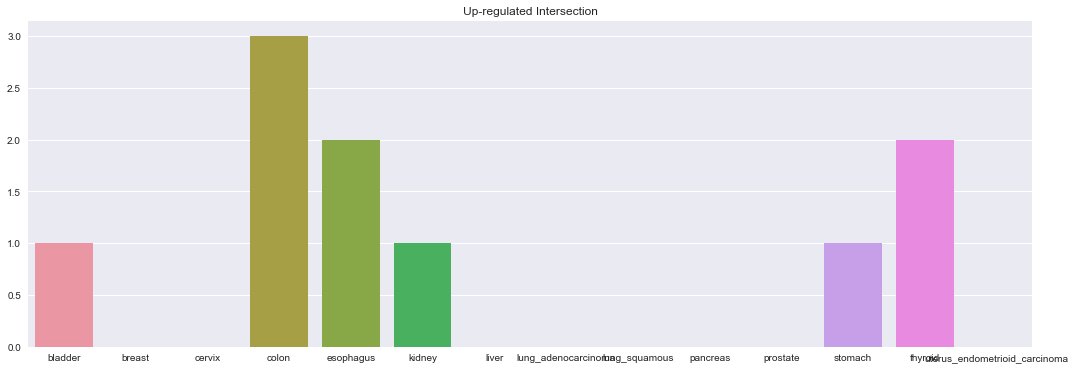

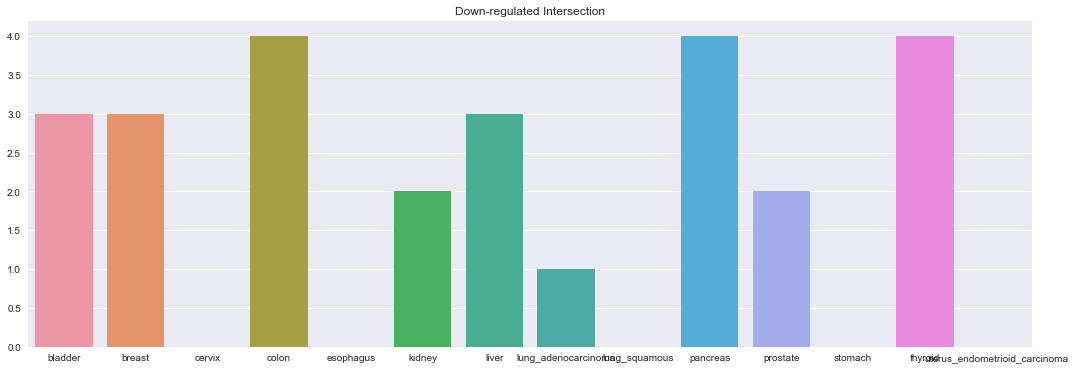

In [79]:
fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(tissues, up_intersect, ax=ax)
plt.title('Up-regulated Intersection')
plt.show()

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(tissues, down_intersect, ax=ax)
plt.title('Down-regulated Intersection');

## Matched Intersection to Cancer Predisposition Gene List

Regardless of Up / Down regulation

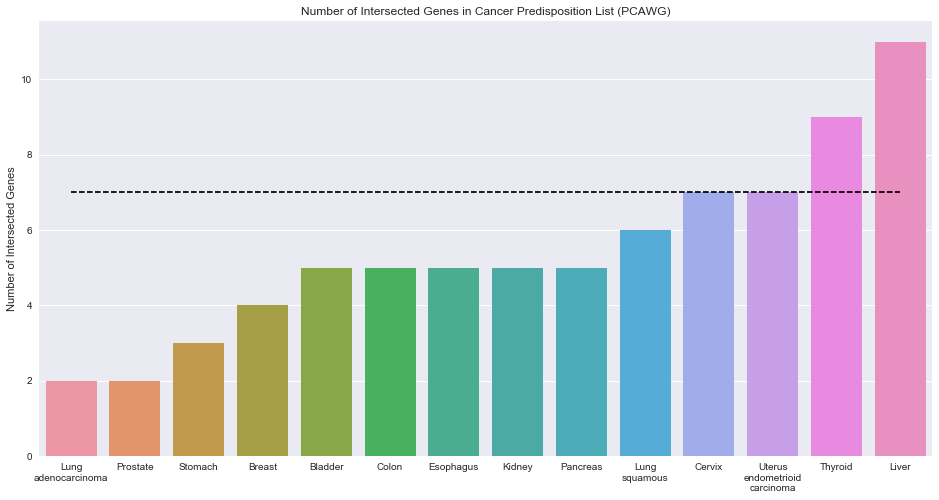

In [80]:
ax.scatter([x for x in xrange(len(tissues))], [7 for _ in xrange(len(tissues))])
cp_intersect = [len(cp_genes.intersection(set(matched_results[x].head(n).index))) for x in tissues]

x, y = zip_sort(label_fix(tissues), cp_intersect)
f, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x, y, ax=ax)
ax.plot([x for x in xrange(len(tissues))], [7 for _ in xrange(len(tissues))], 'k--')
plt.title('Number of Intersected Genes in Cancer Predisposition List (PCAWG)')
plt.ylabel('Number of Intersected Genes');

In [20]:
results['cervix'].head(100)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geneId
UHRF1,5548.690812,6.511175,0.373737,17.421822,5.635391e-68,1.013187e-63,ENSG00000276043.4
KIF18B,1905.990856,6.459040,0.387276,16.678140,1.890128e-62,1.699131e-58,ENSG00000186185.13
TROAP,2190.213854,6.035641,0.365706,16.504070,3.429774e-61,2.055464e-57,ENSG00000135451.12
CDC6,2859.217983,5.421483,0.329003,16.478523,5.234787e-61,2.352906e-57,ENSG00000094804.9
NEK2,1967.581940,6.177862,0.375717,16.442877,9.433219e-61,3.391997e-57,ENSG00000117650.12
CDCA8,2464.203813,5.127971,0.315922,16.231746,3.007821e-59,9.012937e-56,ENSG00000134690.10
TPX2,7808.114567,5.612169,0.350266,16.022589,8.887177e-58,2.282608e-54,ENSG00000088325.15
TOP2A,12254.706133,5.655834,0.357026,15.841505,1.609229e-56,3.616542e-53,ENSG00000131747.14
KIF2C,3789.418317,5.033216,0.320507,15.703927,1.421636e-55,2.839955e-52,ENSG00000142945.12
FOXM1,5501.401210,5.861893,0.375680,15.603421,6.899571e-55,1.240474e-51,ENSG00000111206.12
